## Изменение цены задания в Толоке пропорционально радиусу от центра города

In [46]:
#импорт библиотек
import pandas as pd
import numpy as np
#работа с геоданными
import geopandas as gpd
from shapely.geometry import Point
#скачивание данных через api
import requests
#визуализация
import matplotlib.pyplot as plt
#подсчет формул
from math import radians, cos, sin, asin, sqrt 

#clustering
from h3 import h3
from folium import Map
import folium
import webbrowser
import os

In [18]:
#Расстояние между двумя точками по формуле
def distance(lat1 , lon1, lat2, lon2): 
      
    # The math module contains a function named 
    # radians which converts from degrees to radians. 
    lon1 = radians(lon1) 
    lon2 = radians(lon2) 
    lat1 = radians(lat1) 
    lat2 = radians(lat2) 
       
    # Haversine formula  
    dlon = lon2 - lon1  
    dlat = lat2 - lat1 
    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
  
    c = 2 * asin(sqrt(a))  
     
    # Radius of earth in kilometers. Use 3956 for miles 
    r = 6371
       
    # calculate the result 
    return(c * r) 

In [19]:
#Расстояние между двумя точками с помощью проекций
def calculateDistance(row, dest_geom, src_col='geometry', target_col='distance'):
    """
    Calculates the distance between a single Shapely Point geometry and a GeoDataFrame with Point geometries.

    Parameters
    ----------
    dest_geom : shapely.Point
        A single Shapely Point geometry to which the distances will be calculated to.
    src_col : str
        A name of the column that has the Shapely Point objects from where the distances will be calculated from.
    target_col : str
        A name of the target column where the result will be stored.
    """
    # Calculate the distances
    dist = row[src_col].distance(dest_geom)
    # Tranform into kilometers
    dist_km = dist/1000
    # Assign the distance to the original data
    row[target_col] = dist_km
    return row

The create_map function creates and populates a folium map from the given clusters dictionary. Each value of the dictionary is also a dictionary with two recognizable keys: geom and count. The value associated with the geom key is the list of locations of the hexagon's vertices. The value associated with the count key contains the number of accidents counted within this shape.

source = https://github.com/joaofig/uk-accidents/blob/master/uk-accident-h3.ipynb

In [96]:
def create_map(clusters):
    # Create the map object
    map = Map(tiles="cartodbpositron", 
          attr= '© <a href="http://www.openstreetmap.org/copyright">OpenStreetMap</a> contributors © <a href="http://cartodb.com/attributions#basemaps">CartoDB</a>')

    # Convert the clusters dictionary items to polygons and add them to the map
    for cluster in clusters.values():
        points = cluster['geom']
        # points = [p[::-1] for p in points]
        tooltip = "{0} accidents".format(cluster['count'])
        polygon = folium.vector_layers.Polygon(locations=points, tooltip=tooltip,
                                               fill=True, 
                                               color= '#ff0000' ,
                                               fill_color='#ff0000', 
                                               fill_opacity=cluster['count']/10, weight=3, opacity=0.4)
        polygon.add_to(map)

    # Determine the map bounding box
    max_lat = df.Latitude.max()
    min_lat = df.Latitude.min()
    max_lon = df.Longitude.max()
    min_lon = df.Longitude.min()
    
    # Fit the map to the bounds
    map.fit_bounds([[min_lat, min_lon], [max_lat, max_lon]])
    
    return map

In [92]:
#The show_map function saves the HTML generated by the map into a file and then opens a new browser tab with its contents.

def show_map(map, file_name):
    map.save(file_name)
    wb = webbrowser.open('file://' + os.path.realpath(file_name), new=2)

### Визуализация границ Москвы

/Users/o-tsvetkova/anaconda3/lib/python3.7/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


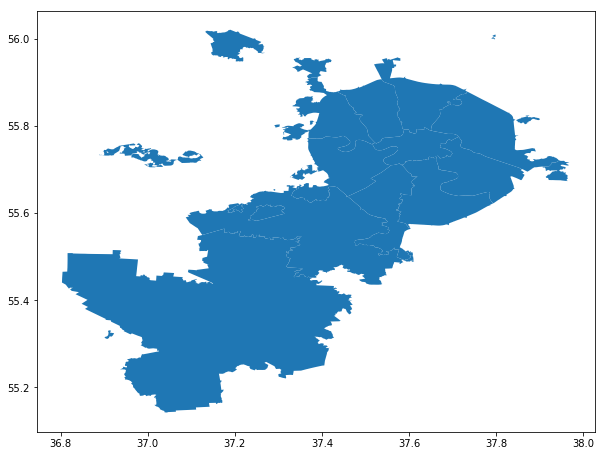

In [20]:
#скачиваем границы Москвы из gis-lab http://gis-lab.info/qa/moscow-atd.html
bound = gpd.read_file('ao.geojson', driver='GeoJSON')
bound.to_crs({"init": "epsg:4326"}, inplace = True)
bound.plot(figsize = (10,15))

/Users/o-tsvetkova/anaconda3/lib/python3.7/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


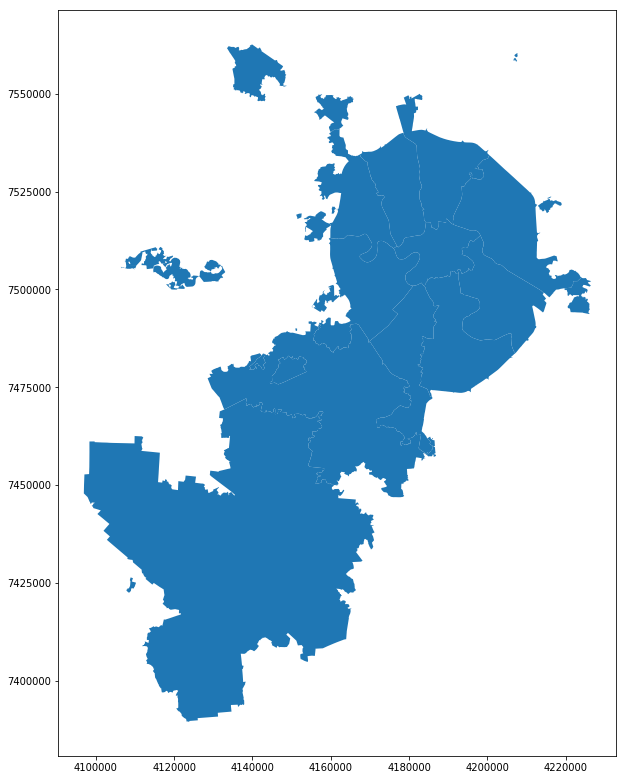

In [21]:
#Проекция меркатора
bound.to_crs({"init": "epsg:3857"}, ).plot(figsize = (10,15))

/Users/o-tsvetkova/anaconda3/lib/python3.7/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


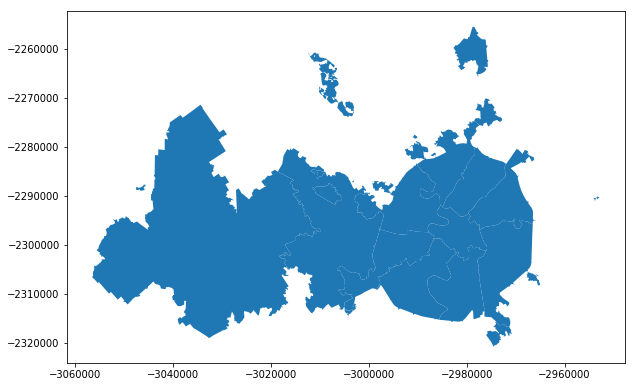

In [22]:
#Проекция Ламберта
bound.to_crs({"init": "epsg:3576"}, ).plot(figsize = (10,15))

### Скачиваем данные из Портала открытых данных г. Москвы

In [23]:
#api_key к данным . Подробнее на https://apidata.mos.ru/Docs#apiKeys
f = open('data_mos_ru_api.txt')
api_key_mos_ru = f.readline()

In [24]:
#скачиваем данные (данные взяты из https://data.mos.ru/opendata/7708308010-ledovye-polya-krytye)

#Крытые ледовые поля
id_dataset = '1232'
response = requests.get('https://apidata.mos.ru/v1/features/' + id_dataset + '?api_key=' + api_key_mos_ru + '&$top=100')

print(response)


<Response [200]>


In [25]:
dataset = gpd.read_file(response.content.decode(), driver='GeoJSON')
#Geographic projection, Latitude/Longitude - означает, что координаты даны в полярных угловых координатах
dataset.to_crs({"init": "epsg:4326"},inplace = True)
dataset.head()

/Users/o-tsvetkova/anaconda3/lib/python3.7/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


,DatasetId,VersionNumber,ReleaseNumber,RowId,Attributes,geometry
0,1232,10,75,None,"{'global_id': 281852691, 'ObjectName': 'Крытое...",POINT (37.68988 55.74167)
1,1232,10,75,None,"{'global_id': 281852864, 'ObjectName': 'Крытое...",POINT (37.73629 55.73192)
2,1232,10,75,None,"{'global_id': 281853202, 'ObjectName': 'Крытое...",POINT (37.53442 55.88706)
3,1232,10,75,None,"{'global_id': 281853238, 'ObjectName': 'Дворец...",POINT (37.53960 55.78683)
4,1232,10,75,None,"{'global_id': 281853378, 'ObjectName': 'Крытое...",POINT (37.35159 55.64598)


In [26]:
# центр Москвы
m_lat = 55.7522
m_lon = 37.6156
df = pd.DataFrame({'City': ['Moscow'], 'Latitude': [55.7522], 'Longitude': [37.6156]})
mos_c = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.Longitude, df.Latitude), crs = {"init": "epsg:4326"})

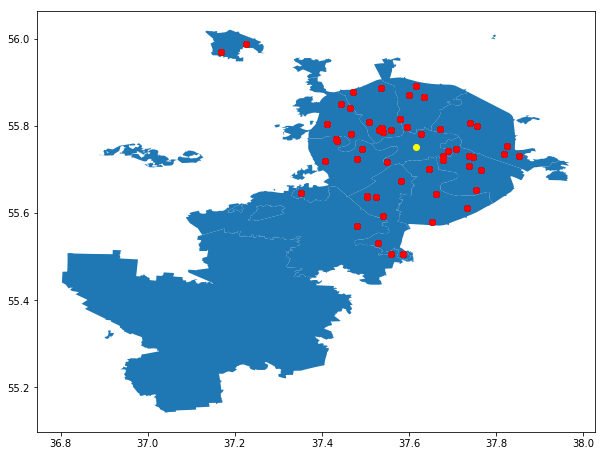

In [27]:
#Визуализация

fig, ax = plt.subplots(figsize = (10,30))
#Границы Москвы
bound.plot(ax = ax )
#Катки
dataset.plot(ax=ax, color="white", edgecolor="black")
dataset.plot(ax=ax, color="red",  figsize = (10,20))

#Центр Москвы
mos_c.plot(ax = ax , color = 'yellow')

# h3

In [69]:
h3_level = 6

In [70]:
def lat_lng_to_h3(row):
    return h3.geo_to_h3(row['Latitude'], row['Longitude'], h3_level)

In [71]:
dataset['Longitude'] = dataset['geometry'].x
dataset['Latitude'] = dataset['geometry'].y

In [72]:
#make h3 cluster
dataset['h3'] = dataset.apply(lat_lng_to_h3, axis=1)

In [73]:
#count points for each cluster
clusters = dict()

for index, row in dataset.iterrows():
    key = row['h3']
    if key in clusters:
        clusters[key]['count'] += 1
    else:
        clusters[key] = {"count": 1,
                         "geom": h3.h3_to_geo_boundary(h3_address=key)}

In [97]:
map = create_map(clusters)

In [98]:
show_map(map, "map_{0}.html".format(h3_level))